In [20]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Import data

In [2]:
# integrated_data = pd.read_csv("../data/processed/burke_ortizbobea_integrated_dataset.csv")
integrated_data = pd.read_csv("../data/processed/burke_ortizbobea_integrated_dataset_with_custom_temp.csv")

# Build integrated Burke-BobeaOrtiz model

In [27]:
with pm.Model() as model:

    temp_prior = pm.Normal("temp_prior", 0, 30)
    temp_std = pm.HalfNormal("temp_std", 30)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=integrated_data["Unweighted_Temp"])
    
    temp_gdp_change_coef = pm.Normal('temp_gdp_change_coef',0,10)
    temp_gdp_change_coef2 = pm.Normal('temp_gdp_change_coef2',0,10)
    temp_gdp_change_intercept = pm.Normal('temp_gdp_change_intercept',0,10)
    
    gdp_change_prior = pm.Deterministic(
        "gdp_change_prior", 
        temp_gdp_change_intercept + 
        (temp_gdp_change_coef * temp_posterior) + 
        (temp_gdp_change_coef2 * pt.sqr(temp_posterior))
    )
    gdp_change_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_change_posterior = pm.Normal('gdp_change_posterior', mu=gdp_change_prior, sigma=gdp_change_std, observed=integrated_data["ln_GDP_Change"])
    
    temp_tfp_change_coef = pm.Normal('temp_tfp_change_coef',0,10)
    temp_tfp_change_coef2 = pm.Normal('temp_tfp_change_coef2',0,10)
    temp_tfp_change_intercept = pm.Normal('temp_tfp_change_intercept',0,10)
    
    tfp_change_prior = pm.Deterministic(
        "tfp_prior", 
        temp_tfp_change_intercept + 
        (temp_tfp_change_coef * temp_posterior) + 
        (temp_tfp_change_coef2 * pt.sqr(temp_posterior))
    )
    
    tfp_change_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_change_prior, sigma=tfp_change_std, observed=integrated_data["ln_TFP_Change"])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

with open ('../models/burke_bobeaOrtiz_integrated.pkl', 'wb') as buff:
    pkl.dump ({'prior': prior, 'trace': trace, "posterior": posterior}, buff)

/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in gdp_change_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in tfp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Varia

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 597 seconds.
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x281C50AC0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x281C509E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x28D1F7900>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_change_posterior_observed, g

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_13075/283470424.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


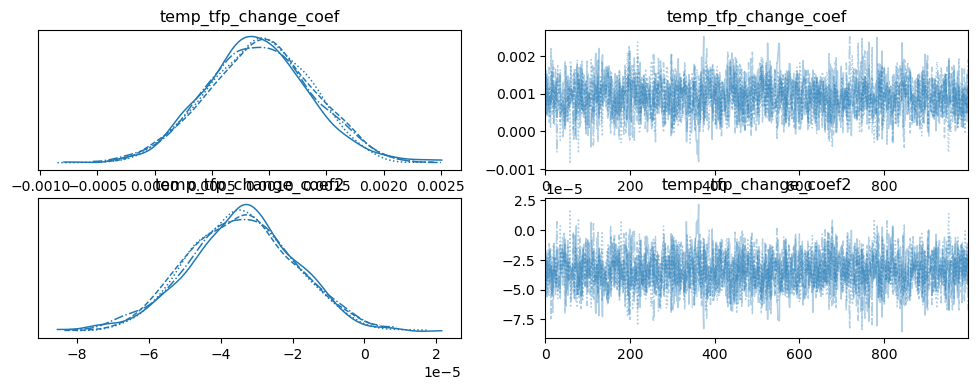

In [11]:
with open('../models/burke_bobeaOrtiz_integrated.pkl', 'rb') as buff:
    data = pkl.load(buff)
    posterior = data["posterior"]
fig = az.plot_trace(posterior, var_names=["temp_tfp_change_coef","temp_tfp_change_coef2"]).ravel()[0].figure
fig.show()

# Build isolated Burke model

In [33]:
with pm.Model() as model:
    
    burke_temp_prior = pm.Normal("temp_prior", 0, 30, shape=(1,3))
    burke_temp_std = pm.HalfNormal("temp_std", 30, shape=3)
    burke_temp_mixture_weights = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    burke_temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        burke_temp_mixture_weights, 
        burke_temp_prior, 
        burke_temp_std, 
        observed=integrated_data["Unweighted_Temp"]
    )
    
    burke_temp_coef = pm.Normal('temp_coef',0,10)
    burke_temp_coef_2 = pm.Normal('temp_coef_2',0,10)
    burke_temp_intercept = pm.Normal('temp_intercept',0,10)
    
    gdp_prior = pm.Deterministic(
        "gdp_prior", 
        burke_temp_intercept + 
        (burke_temp_coef * burke_temp_posterior) + 
        (burke_temp_coef_2 * pt.sqr(burke_temp_posterior))
    )
    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=integrated_data["ln_TFP_Change"])
    
    burke_prior = pm.sample_prior_predictive()
    burke_trace = pm.sample()
    burke_posterior = pm.sample_posterior_predictive(burke_trace, extend_inferencedata=True)

# with open ('../models/burke_with_unweighted_temp_real_normalized_gdp.pkl', 'wb') as buff:
#     pkl.dump ({'prior': burke_prior, 'trace': burke_trace, "posterior": burke_posterior}, buff)

/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x168F1AC80>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_posterior_observed, gdp_posterior_unobserved, gdp_std, temp_coef, temp_coef_2, temp_intercept, temp_mixture_weights, temp_post

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 550 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2BDCAC820>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [gdp_posterior_observed, gdp_posterior_unobserved, temp_posterior_observed]


# Plot results

In [19]:
temp_13_gdp = []
temp_22_gdp = []
for i in range(10):
    for j in range(len(integrated_data["Unweighted_Temp"])):
        gdp_val = posterior["gdp_posterior"][0][i][j].data
        temp_val = posterior["temp_posterior"][0][i][j].data
        if temp_val > 12.5 and temp_val < 13.5:
            temp_13_gdp.append(gdp_val)
        elif temp_val > 21.5 and temp_val < 22.5:
            temp_22_gdp.append(gdp_val)

4809
2657


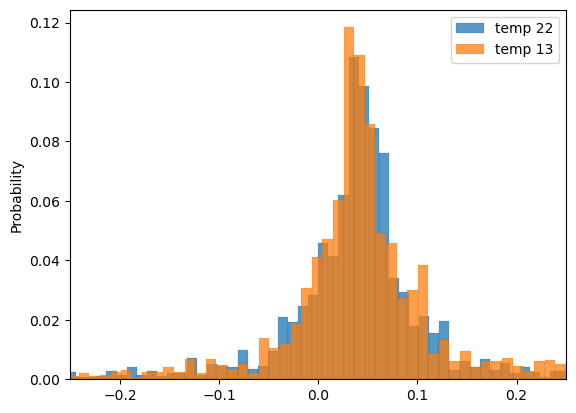

In [27]:
print(len(temp_22_gdp))
print(len(temp_13_gdp))
fig, ax = plt.subplots()
sns.histplot(data=np.array(temp_22_gdp)[:2500], stat='probability', ax=ax, label="temp 22")
sns.histplot(data=np.array(temp_13_gdp)[:2500], stat='probability', ax=ax, label="temp 13")
ax.set_xlim(-.25,.25)
ax.legend()

In [18]:
print(np.mean(posterior[coef1][0].data))
print(np.mean(posterior[coef2][0].data))
print(np.mean(posterior[intercept][0].data))

0.029110772491340583
-0.0009173192618794024
-0.14856494878878873


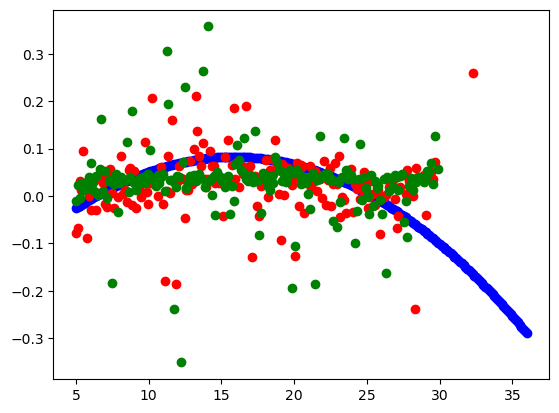

In [14]:
with open('../models/burke_with_weighted_temp.pkl', 'rb') as buff:
    data = pkl.load(buff)
posterior = data["posterior"]["posterior"]

coef1 = "temp_coef"
coef2 = "temp_coef_2"
intercept = "temp_intercept"
ind_var = "temp_posterior"
dep_var = "gdp_posterior"
ind_var_column = "Unweighted_Temp"
dep_var_column = "ln_GDP_Change"

x_vals = []
regression_y_vals = []
sampled_y_vals = []
observed_y_vals = []
coef1_mean = np.mean(posterior[coef1][0].data)
coef2_mean = np.mean(posterior[coef2][0].data)
intercept_mean = np.mean(posterior[intercept][0].data)

# min_x_val = np.min(posterior[ind_var][0].data)
# max_x_val = np.max(posterior[ind_var][0].data)
min_x_val = 5
max_x_val = 36

increment = abs(max_x_val - min_x_val) / 500

for x_val in np.linspace(
    min_x_val,
    max_x_val,
    num=250
):  
    x_vals.append(x_val)
    regression_y_vals.append((coef1_mean * x_val) + (coef2_mean * (x_val**2)) + intercept_mean)
    sampled_data = []
    for sample in range(len(integrated_data[dep_var_column])):
        sample_val = posterior[ind_var][0].data[0][sample]
        if sample_val >= x_val-increment and sample_val <= x_val+increment:
            sampled_data.append(posterior[dep_var][0].data[0][sample])
    sampled_y_vals.append(np.mean(sampled_data))
    observed_data = []
    for index, observed_val in enumerate(integrated_data[ind_var_column]):
        if observed_val >= x_val-increment and observed_val <= x_val+increment:
            if not np.isnan(integrated_data[dep_var_column][index]):
                observed_data.append(integrated_data[dep_var_column][index])
    observed_y_vals.append(np.mean(observed_data))

plt.scatter(x_vals, regression_y_vals, color="blue")
plt.scatter(x_vals, sampled_y_vals, color="red")
plt.scatter(x_vals, observed_y_vals, color="green")
plt.show()

# Build isolated Ortiz-Bobea Model

In [42]:
with pm.Model() as model:
    
    ob_temp_prior = pm.Normal("temp_prior", 0, 10)
    ob_temp_std = pm.HalfNormal("temp_std", 10)
    ob_temp_posterior = pm.Normal("temp_posterior", ob_temp_prior, ob_temp_std, observed=integrated_data["Unweighted_Temp"])
    
    ob_temp_coef = pm.Normal('temp_coef',0,10)
    ob_temp_coef_2 = pm.Normal('temp_coef_2',0,10)
    ob_temp_intercept = pm.Normal('temp_intercept',0,10)
    
    tfp_prior = pm.Deterministic("tfp_prior", ob_temp_intercept + (ob_temp_coef * ob_temp_posterior) + (ob_temp_coef_2 * pt.sqr(ob_temp_posterior)))
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=integrated_data["ln_TFP_Change"])
    
    ob_prior = pm.sample_prior_predictive()
    ob_trace = pm.sample()
    ob_posterior = pm.sample_posterior_predictive(ob_trace, extend_inferencedata=True)

with open ('../models/ortizbobea_with_unweighted_temp_and_tfp_real.pkl', 'wb') as buff:
    pkl.dump ({'prior': ob_prior, 'trace': ob_trace, "posterior": ob_posterior}, buff)

/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in tfp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x151B6B2E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable Random

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1526A32E0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1524A0120>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [temp_posterior_observed, tfp_posterior_observed, tfp_posterior_unobserved]


# Plot Ortiz-Bobea results

In [50]:
temp_vars = ["Unweighted_Temp"]#, "Unweighted_Temp_Change", "Ag_Weighted_Temp_Change"]
for index, model in enumerate(["unweighted_temp_real"]):#, "unweighted_temp", "weighted_temp"]):
    with open(f'../models/ortizbobea_with_{model}.pkl', 'rb') as buff:
        data = pkl.load(buff)
    ob_posterior = data["posterior"]
    x_vals = []
    regression_y_vals = []
    sampled_y_vals = []
    observed_y_vals = []

    temp_var = temp_vars[index]
    
    coef1_mean = np.mean(ob_posterior["posterior"]["temp_coef"][0].data)
    coef2_mean = np.mean(ob_posterior["posterior"]["temp_coef_2"][0].data)
    intercept_mean = np.mean(ob_posterior["posterior"]["temp_intercept"][0].data)
    
    for temp in np.linspace(-5,36,num=250):  
        x_vals.append(temp)
        regression_y_vals.append((coef1_mean * temp) + (coef2_mean * (temp**2)) + intercept_mean)
        sampled_gdp_change = []
        for sample in range(len(integrated_data[temp_var])):
            temp_val = ob_posterior["posterior"]["temp_posterior"][0].data[0][sample]
            if temp_val >= temp-.08 and temp_val <= temp+.08:
                sampled_gdp_change.append(ob_posterior["posterior"]["tfp_posterior"][0].data[0][sample])
        sampled_y_vals.append(np.mean(sampled_gdp_change))
        observed_gdp_change = []
        for index, observed_temp in enumerate(integrated_data[temp_var]):
            if observed_temp >= temp-.08 and observed_temp <= temp+.08:
                if not np.isnan(integrated_data["ln_TFP_Change"][index]):
                    observed_gdp_change.append(integrated_data["ln_TFP_Change"][index])
        observed_y_vals.append(np.mean(observed_gdp_change))
        
    plt.scatter(x_vals, regression_y_vals, color="blue")
    plt.scatter(x_vals, sampled_y_vals, color="red")
    plt.scatter(x_vals, observed_y_vals, color="green")
    plt.savefig(f'../figures/ortiz-bobea/{model}')
    plt.close()

# Ask conditional probability questions about temperature

In [24]:
pop_weighted_temps = []
ag_weighted_temps = []
for unweighted_temp, weighted_temps in transformation.items():
    if unweighted_temp > 10.9 and unweighted_temp < 11.1:
        for weighted_temp in transformation[unweighted_temp]["pop_weighted"]:
            pop_weighted_temps.append(weighted_temp)
        for weighted_temp in transformation[unweighted_temp]["ag_weighted"]:
            ag_weighted_temps.append(weighted_temp)
print(np.mean(pop_weighted_temps))
print(np.std(pop_weighted_temps))
print(np.mean(ag_weighted_temps))
print(np.std(ag_weighted_temps))

12.122173913043476
1.7206241449006587
11.093975945805719
1.815898184863333


# Convert QGIS temperature output files to single unweighted temperature file

In [25]:
curr_month = 1
curr_year = 1900
dir = "../data/processed/temp_by_country_raster_band/"
monthly_temp_data_by_country = {"Country":[],"Year":[],"Month":[],"Mean_Temp":[]}
for file in sorted(os.listdir(dir)):
    if "country_temp_raster_band_" in file:
        month_file = pd.read_csv(dir + file)
        country_codes = month_file["GMI_CNTRY"]
        mean_temps = month_file["_mean"]
        for index in range(len(country_codes)):
            country = country_codes[index]
            temp = mean_temps[index]
            monthly_temp_data_by_country["Country"].append(country)
            monthly_temp_data_by_country["Year"].append(curr_year)
            monthly_temp_data_by_country["Month"].append(curr_month)
            monthly_temp_data_by_country["Mean_Temp"].append(temp)
        curr_month += 1
        if curr_month == 13:
            curr_month = 1
            curr_year += 1
zipped = zip(monthly_temp_data_by_country["Country"],monthly_temp_data_by_country["Year"],monthly_temp_data_by_country["Month"],monthly_temp_data_by_country["Mean_Temp"])
zipped = list(sorted(zipped))
monthly_temp_data_by_country["Country"] = [row[0] for row in zipped]
monthly_temp_data_by_country["Year"] = [row[1] for row in zipped]
monthly_temp_data_by_country["Month"] = [row[2] for row in zipped]
monthly_temp_data_by_country["Mean_Temp"] = [row[3] for row in zipped]
pd.DataFrame.from_dict(monthly_temp_data_by_country).to_csv("../data/processed/unweighted_monthly_temp_by_country.csv")          

# Create integrated dataset with unweighted temp for burke and ortiz-bobea

In [38]:
integrated_data_dict = {"Country":[],"Year":[],"Unweighted_Temp":[],"Unweighted_Temp_Change":[],"Pop_Weighted_Temp_burke":[],"Pop_Weighted_Temp_custom":[],"Ag_Weighted_Temp":[],"Ag_Weighted_Temp_Change":[],"Normalized_GDP":[],"ln_GDP_Change":[],"ln_TFP_Change":[]}
# unweighted_temp = pd.read_csv("../data/processed/unweighted_monthly_temp_by_country.csv")
unweighted_temp = pd.read_csv("../data/burke/data/input/custom_monthly_unweighted_temp_by_country.csv")
burke_data = pd.read_csv("../data/processed/burke_country_temp_gdp.csv")
ortizbobea_data = pd.read_csv("../data/processed/ortiz_bobea_country_temp_tfp_output.csv")
custom_poptemp_data = pd.read_csv("../data/burke/data/input/custom_monthly_popweighted_temp_by_country.csv")
# all_countries = set(ortizbobea_data["Country"]).intersection(set(burke_data["Country"]))
all_countries = set(ortizbobea_data["Country"]).intersection(set(burke_data["Country"]))
all_years = set(ortizbobea_data["Year"]).intersection(set(burke_data["Year"]))
last_gdp = np.NaN
for index, country in enumerate(list(all_countries)):
    country_gdp_data = []
    for year in all_years:
        burke_row = burke_data.loc[(burke_data["Country"] == country) & (burke_data["Year"] == year)]
        ob_row = ortizbobea_data.loc[(ortizbobea_data["Country"] == country) & (ortizbobea_data["Year"] == year)]
        custom_temp_row = custom_poptemp_data.loc[(custom_poptemp_data["Country"] == country) & (custom_poptemp_data["Year"] == year)]
        # hacky way to eliminate multiple-occurring and non-existent country codes in custom data
        try:
            custom_temp_row["Avg_PopWeighted_Temp"].item()
        except ValueError:
            continue
        integrated_data_dict["Country"].append(country)
        integrated_data_dict["Year"].append(year)
        unweighted_temps = list(unweighted_temp.loc[(unweighted_temp["Country"] == country) & (unweighted_temp["Year"] == year)]["Mean_Temp"])
        integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
        if len(country_gdp_data) == 0:
            integrated_data_dict["Unweighted_Temp_Change"].append(np.NaN)
        else:
            integrated_data_dict["Unweighted_Temp_Change"].append(integrated_data_dict["Unweighted_Temp"][-1]-integrated_data_dict["Unweighted_Temp"][-2])
        try:
            integrated_data_dict["Pop_Weighted_Temp_burke"].append(burke_row["Temp"].item())
        except AttributeError:
            integrated_data_dict["Pop_Weighted_Temp_burke"].append(np.NaN)
        try:
            integrated_data_dict["Pop_Weighted_Temp_custom"].append(custom_temp_row["Avg_PopWeighted_Temp"].item())
        except AttributeError:
            integrated_data_dict["Pop_Weighted_Temp_custom"].append(np.NaN)
        try:
            integrated_data_dict["Ag_Weighted_Temp"].append(ob_row["Temp"].item())
        except AttributeError:
            integrated_data_dict["Ag_Weighted_Temp"].append(np.NaN)
        try:
            integrated_data_dict["Ag_Weighted_Temp_Change"].append(ob_row["Temp_change"].item())
        except AttributeError:
            integrated_data_dict["Ag_Weighted_Temp_Change"].append(np.NaN)
        try:
            integrated_data_dict["ln_TFP_Change"].append(ob_row["ln_TFP_change"].item())
        except AttributeError:
            integrated_data_dict["ln_TFP_Change"].append(np.NaN)
        try:
            curr_gdp = burke_row["GDP"].item()
        except AttributeError:
            curr_gdp = np.NaN
        country_gdp_data.append(curr_gdp)
        if np.isnan(last_gdp) or np.isnan(curr_gdp):
            integrated_data_dict["ln_GDP_Change"].append(np.NaN)
        else:
            integrated_data_dict["ln_GDP_Change"].append(np.log(curr_gdp)-np.log(last_gdp))
        last_gdp = curr_gdp
    if len(country_gdp_data) > 0:
        normalized_gdp_by_country = StandardScaler().fit_transform(np.array(country_gdp_data).reshape(-1, 1)).flatten()
        for elem in normalized_gdp_by_country:
            integrated_data_dict["Normalized_GDP"].append(elem)
pd.DataFrame.from_dict(integrated_data_dict).to_csv("../data/processed/burke_ortizbobea_integrated_dataset_with_custom_temp.csv")       

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_6130/3765098503.py:25: RuntimeWarning: Mean of empty slice
  integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_6130/3765098503.py:25: RuntimeWarning: Mean of empty slice
  integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_6130/3765098503.py:25: RuntimeWarning: Mean of empty slice
  integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_6130/3765098503.py:25: RuntimeWarning: Mean of empty slice
  integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
